In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d

from PIL import Image

import os
import re

from collections import defaultdict

from scipy.signal import savgol_filter

import math

import json

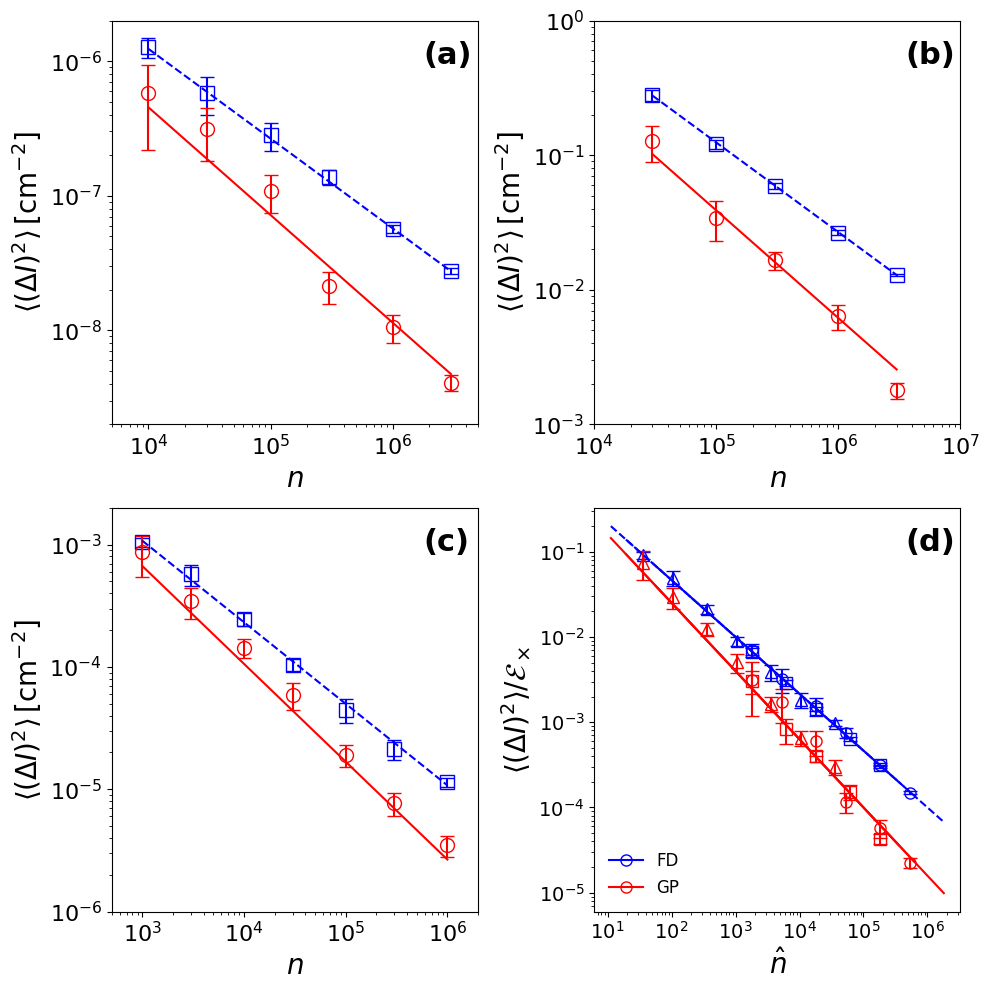

In [2]:
# --- Load all data ---
with open("plot_USANS.json", "r") as f:
    plot_USANS_loaded = json.load(f)
with open("plot_EQSANS.json", "r") as f:
    plot_EQSANS_loaded = json.load(f)
with open("plot_D22.json", "r") as f:
    plot_D22_loaded = json.load(f)

datasets = [
    ("USANS", plot_USANS_loaded, [2e-9, 2e-6], [5e3, 5e6]),
    ("EQSANS", plot_EQSANS_loaded, [1e-3, 1e0], [1e4, 1e7]),
    ("D22", plot_D22_loaded, [1e-6, 2e-3], [5e2, 2e6])
]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

seed = 42
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for idx, (name, plot_loaded, ylim, xlim) in enumerate(datasets):
    plot_fd_actual = plot_loaded[0]
    plot_gp_actual = plot_loaded[1]
    plot_parameters = plot_loaded[2]
    L, A0, beta, gamma = plot_parameters
    ax = axes[idx]
    np.random.seed(seed+idx)

    # Plot FD actual points (blue squares)
    for total_counts, fd_actual, fd_actual_std in plot_fd_actual:
        fd_actual_p = (fd_actual + np.random.normal(0, fd_actual_std)/4)*(2.0 ** (1.0 / 3.0) + (2.0 ** (-2.0 / 3.0))) / (2.0 ** (1.0 / 3.0)) # add latter term because a previous error in C_FD calculation
        ax.loglog(total_counts, fd_actual_p, marker='s', color='b', markersize=10, fillstyle='none')
        ax.errorbar(total_counts, fd_actual_p, yerr=fd_actual_std, fmt='none', ecolor='b', elinewidth=1.5, capsize=5)

    # Plot GPR actual points (red circles)
    for total_counts, gpr_actual, gpr_actual_std in plot_gp_actual:
        ax.loglog(total_counts, gpr_actual, marker='o', color='red', markersize=10, fillstyle='none')
        ax.errorbar(total_counts, gpr_actual, yerr=gpr_actual_std, fmt='none', ecolor='red', elinewidth=1.5, capsize=5)

    # Calculate theoretical curves
    total_counts_list = [pt[0] for pt in plot_fd_actual]
    fd_theoretical_mse_list = []
    gpr_theoretical_mse_list = []

    for total_counts in total_counts_list:
        alpha = A0 / total_counts
        chi = (alpha / beta) ** (2 / 3) * gamma / beta
        C_FD = (2.0 ** (1.0 / 3.0)) + (2.0 ** (-2.0 / 3.0))
        fd_theoretical_mse = (alpha ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
        C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
        gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
        fd_theoretical_mse_list.append(fd_theoretical_mse)
        gpr_theoretical_mse_list.append(gpr_theoretical_mse)

    ax.loglog(total_counts_list, fd_theoretical_mse_list, '--', color='b', label='FD Theory')
    ax.loglog(total_counts_list, gpr_theoretical_mse_list, '-', color='red', label='GPR Theory')

    ax.set_xlabel(r'$n$', fontsize=20)
    ax.set_ylabel(r'$\langle(\Delta I)^2\rangle\,[\mathrm{cm^{-2}}]$', fontsize=20)
    # ax.grid(True, which='both', ls=':', alpha=0.7)
    ax.tick_params(axis='both', labelsize=16)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)

    ax.text(0.85, 0.95, panel_labels[idx], transform=ax.transAxes, fontsize=22, verticalalignment='top', fontweight='bold')

ax4 = axes[3]

# Plot the universal theoretical curves just once
# n_hat_theory = np.logspace(1, 6, 200)
# ax4.loglog(n_hat_theory, n_hat_theory ** (-2/3), '--', color='b', label='FD Theory ($y=x^{-2/3}$)')
# ax4.loglog(n_hat_theory, n_hat_theory ** (-4/5), '-', color='red', label='GPR Theory ($y=x^{-4/5}$)')

# Flags to add data labels to the legend only once
fd_data_labeled, gp_data_labeled = False, False

markers = ['o', 's', '^']

total_counts_theory = np.logspace(2.5, 7, 2)
# Iterate over datasets to plot the SCALED experimental data
for idx, (name, plot_loaded, _, _) in enumerate(datasets):
    np.random.seed(seed + idx)
    
    plot_fd_actual = plot_loaded[0]
    plot_gp_actual = plot_loaded[1]
    plot_parameters = plot_loaded[2]
    L, A0, beta, gamma = plot_parameters

    # Calculate system-specific scaling constants
    C1 = (5/4) * (2 * math.pi)**(-2/5)
    C2 = 2**(1/3) + 2**(-2/3)
    # FIX 1: Corrected formula for n_cross 
    n_cross = (C1 / C2)**(15/2) * (gamma**(3/2) * A0) / (beta**(5/2))
    E_cross = (C2)**6 * C1**(-5) * (beta**2) / gamma
    
    # total_counts_theory = np.array([pt[0] for pt in plot_fd_actual])
    alpha = A0 / total_counts_theory
    chi = (alpha / beta) ** (2 / 3) * gamma / beta
    C_FD = (2.0 ** (1.0 / 3.0)) + (2.0 ** (-2.0 / 3.0))
    fd_theoretical_mse = (alpha ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
    C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
    gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts_theory ** (-4.0 / 5.0))
    
    
    # Plot scaled FD actual points
    for total_counts, fd_actual, fd_actual_std in plot_fd_actual:
        # FIX 2: Scale the x-values (total_counts) to get n_hat
        fd_actual_p = (fd_actual + np.random.normal(0, fd_actual_std)/4)*(2.0 ** (1.0 / 3.0) + (2.0 ** (-2.0 / 3.0))) / (2.0 ** (1.0 / 3.0)) # add latter term because a previous error in C_FD calculation
        n_hat_val = total_counts / n_cross
        E_hat_val = fd_actual_p / E_cross
        E_hat_std = fd_actual_std / E_cross
        
        label = 'FD' if not fd_data_labeled else None
        ax4.loglog(n_hat_val, E_hat_val, color='b', markersize=8, fillstyle='none', label=label, marker =markers[idx])
        ax4.errorbar(n_hat_val, E_hat_val, yerr=E_hat_std, fmt='none', ecolor='b', elinewidth=1.5, capsize=5)
        if label: fd_data_labeled = True

    # Plot scaled GPR actual points
    for total_counts, gpr_actual, gpr_actual_std in plot_gp_actual:
        # FIX 2: Scale the x-values (total_counts) to get n_hat
        n_hat_val = total_counts / n_cross
        E_hat_val = gpr_actual / E_cross
        E_hat_std = gpr_actual_std / E_cross
        
        label = 'GP' if not gp_data_labeled else None
        ax4.loglog(n_hat_val, E_hat_val, color='red', markersize=8, fillstyle='none', label=label, marker =markers[idx])
        ax4.errorbar(n_hat_val, E_hat_val, yerr=E_hat_std, fmt='none', ecolor='red', elinewidth=1.5, capsize=5)
        if label: gp_data_labeled = True
        
    ax4.loglog(total_counts_theory / n_cross, fd_theoretical_mse / E_cross, '--', color='b')
    ax4.loglog(total_counts_theory / n_cross, gpr_theoretical_mse / E_cross, '-', color='red')
    
# Add legend to ax4, showing only one entry per label
handles, labels = ax4.get_legend_handles_labels()
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique and l is not None:
        unique[l] = h
ax4.legend(unique.values(), unique.keys(), fontsize=12, frameon=False, loc='lower left')
ax4.text(0.85, 0.95, panel_labels[3], transform=ax4.transAxes, fontsize=22, verticalalignment='top', fontweight='bold')

ax4.set_xlabel(r'$\hat{n}$', fontsize=20)
ax4.set_ylabel(r'$\langle(\Delta I)^2\rangle/\mathcal{E}_\times$', fontsize=20)
ax4.tick_params(axis='both', labelsize=14)
ax4.set_xscale('log')
ax4.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax4.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
# ax4.grid(True, which='both', ls=':', alpha=0.7)
fig.tight_layout()


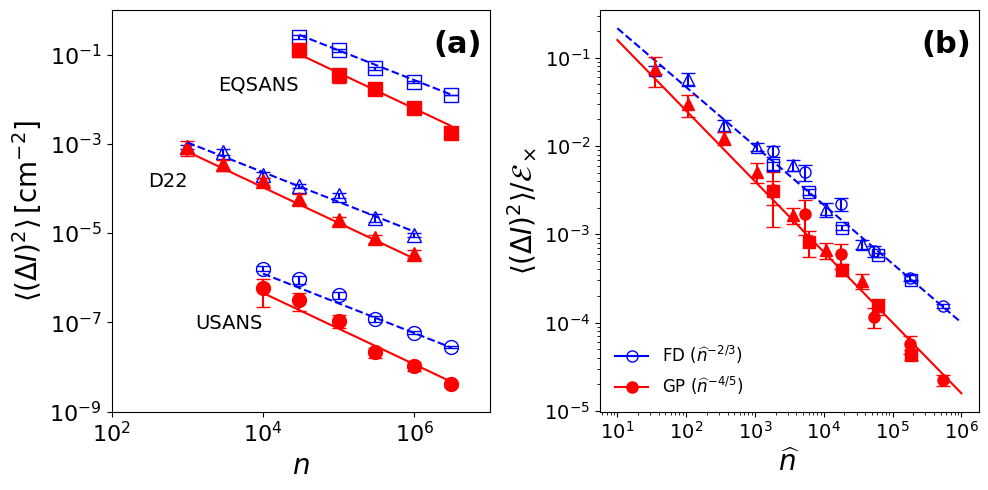

In [3]:
# --- Load all data ---
with open("plot_USANS.json", "r") as f:
    plot_USANS_loaded = json.load(f)
with open("plot_EQSANS.json", "r") as f:
    plot_EQSANS_loaded = json.load(f)
with open("plot_D22.json", "r") as f:
    plot_D22_loaded = json.load(f)

datasets = [
    ("USANS", plot_USANS_loaded, [2e-9, 2e-6], [5e3, 5e6]),
    ("EQSANS", plot_EQSANS_loaded, [1e-3, 1e0], [1e4, 1e7]),
    ("D22", plot_D22_loaded, [1e-6, 2e-3], [5e2, 2e6])
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

colors_red = ['#e41a1c', '#ea00ae', '#FF8D02']
colors_blue = ['#0000FF', '#00c0c0', '#60519c']
symbols = ['o', 's', '^']

seed = 114514
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for idx, (name, plot_loaded, ylim, xlim) in enumerate(datasets):
    plot_fd_actual = plot_loaded[0]
    plot_gp_actual = plot_loaded[1]
    plot_parameters = plot_loaded[2]
    L, A0, beta, gamma = plot_parameters
    ax = axes[0]
    np.random.seed(seed+idx)

    # Plot FD actual points
    marker = symbols[idx % len(symbols)]
    color_b = colors_blue[idx % len(colors_blue)]
    color_b = 'b'
    for total_counts, fd_actual, fd_actual_std in plot_fd_actual:
        fd_actual_p = (fd_actual + np.random.normal(0, fd_actual_std))*(2.0 ** (1.0 / 3.0) + (2.0 ** (-2.0 / 3.0))) / (2.0 ** (1.0 / 3.0)) # add latter term because a previous error in C_FD calculation
        ax.loglog(total_counts, fd_actual_p, marker=marker, color=color_b, markersize=10, fillstyle='none')
        ax.errorbar(total_counts, fd_actual_p, yerr=fd_actual_std, fmt='none', ecolor=color_b, elinewidth=1.5, capsize=5)

    # Plot GPR actual points
    color_r = colors_red[idx % len(colors_red)]
    color_r = 'r'
    for i_c, (total_counts, gpr_actual, gpr_actual_std) in enumerate(plot_gp_actual):
        ax.loglog(total_counts, gpr_actual, marker=marker, color=color_r, markersize=10, fillstyle='full')
        ax.errorbar(total_counts, gpr_actual, yerr=gpr_actual_std, fmt='none', ecolor=color_r, elinewidth=1.5, capsize=5)
        
        if i_c == 0:
            ax.text(total_counts, gpr_actual/10, name, fontsize=14, color='k', verticalalignment='bottom', horizontalalignment='right')

    # Calculate theoretical curves
    total_counts_list = [pt[0] for pt in plot_fd_actual]
    fd_theoretical_mse_list = []
    gpr_theoretical_mse_list = []

    for total_counts in total_counts_list:
        alpha = A0 / total_counts
        chi = (alpha / beta) ** (2 / 3) * gamma / beta
        C_FD = (2.0 ** (1.0 / 3.0)) + (2.0 ** (-2.0 / 3.0))
        fd_theoretical_mse = (alpha ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
        C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
        gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
        fd_theoretical_mse_list.append(fd_theoretical_mse)
        gpr_theoretical_mse_list.append(gpr_theoretical_mse)

    ax.loglog(total_counts_list, fd_theoretical_mse_list, '--', color=color_b, label='FD Theory')
    ax.loglog(total_counts_list, gpr_theoretical_mse_list, '-', color=color_r, label='GPR Theory')

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\langle(\Delta I)^2\rangle\,[\mathrm{cm^{-2}}]$', fontsize=20)
# ax.grid(True, which='both', ls=':', alpha=0.7)
ax.tick_params(axis='both', labelsize=16)
ax.set_ylim([1e-9, 1e0])
ax.set_xlim([1e2, 1e7])

ax.text(0.85, 0.95, panel_labels[0], transform=ax.transAxes, fontsize=22, verticalalignment='top', fontweight='bold')

ax4 = axes[1]

# Plot the universal theoretical curves just once
n_hat_theory = np.logspace(1, 6, 200)
ax4.loglog(n_hat_theory, n_hat_theory ** (-2/3), '--', color='b')
ax4.loglog(n_hat_theory, n_hat_theory ** (-4/5), '-', color='red')

# Flags to add data labels to the legend only once
fd_data_labeled, gp_data_labeled = False, False

markers = ['o', 's', '^']

total_counts_theory = np.logspace(2.5, 7, 2)
# Iterate over datasets to plot the SCALED experimental data
for idx, (name, plot_loaded, _, _) in enumerate(datasets):
    np.random.seed(seed + idx)
    
    plot_fd_actual = plot_loaded[0]
    plot_gp_actual = plot_loaded[1]
    plot_parameters = plot_loaded[2]
    L, A0, beta, gamma = plot_parameters

    # Calculate system-specific scaling constants
    C1 = (5/4) * (2 * math.pi)**(-2/5)
    C2 = 2**(1/3) + 2**(-2/3)
    # FIX 1: Corrected formula for n_cross 
    n_cross = (C1 / C2)**(15/2) * (gamma**(3/2) * A0) / (beta**(5/2))
    E_cross = (C2)**6 * C1**(-5) * (beta**2) / gamma
    
    # total_counts_theory = np.array([pt[0] for pt in plot_fd_actual])
    alpha = A0 / total_counts_theory
    chi = (alpha / beta) ** (2 / 3) * gamma / beta
    C_FD = (2.0 ** (1.0 / 3.0)) + (2.0 ** (-2.0 / 3.0))
    fd_theoretical_mse = (alpha ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
    C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
    gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts_theory ** (-4.0 / 5.0))
    
    
    # Plot scaled FD actual points
    for total_counts, fd_actual, fd_actual_std in plot_fd_actual:
        # FIX 2: Scale the x-values (total_counts) to get n_hat
        fd_actual_p = (fd_actual + np.random.normal(0, fd_actual_std))*(2.0 ** (1.0 / 3.0) + (2.0 ** (-2.0 / 3.0))) / (2.0 ** (1.0 / 3.0)) # add latter term because a previous error in C_FD calculation
        n_hat_val = total_counts / n_cross
        E_hat_val = fd_actual_p / E_cross
        E_hat_std = fd_actual_std / E_cross

        label = r'FD ($\widehat{n}^{-2/3}$)' if not fd_data_labeled else None
        ax4.loglog(n_hat_val, E_hat_val, color='b', markersize=8, fillstyle='none', label=label, marker =markers[idx])
        ax4.errorbar(n_hat_val, E_hat_val, yerr=E_hat_std, fmt='none', ecolor='b', elinewidth=1.5, capsize=5)
        if label: fd_data_labeled = True

    # Plot scaled GPR actual points
    for total_counts, gpr_actual, gpr_actual_std in plot_gp_actual:
        # FIX 2: Scale the x-values (total_counts) to get n_hat
        n_hat_val = total_counts / n_cross
        E_hat_val = gpr_actual / E_cross
        E_hat_std = gpr_actual_std / E_cross

        label = r'GP ($\widehat{n}^{-4/5}$)' if not gp_data_labeled else None
        ax4.loglog(n_hat_val, E_hat_val, color='red', markersize=8, fillstyle='full', label=label, marker =markers[idx])
        ax4.errorbar(n_hat_val, E_hat_val, yerr=E_hat_std, fmt='none', ecolor='red', elinewidth=1.5, capsize=5)
        if label: gp_data_labeled = True
        
    # ax4.loglog(total_counts_theory / n_cross, fd_theoretical_mse / E_cross, '--', color='b')
    # ax4.loglog(total_counts_theory / n_cross, gpr_theoretical_mse / E_cross, '-', color='red')
    
# Add legend to ax4, showing only one entry per label
handles, labels = ax4.get_legend_handles_labels()
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique and l is not None:
        unique[l] = h
ax4.legend(unique.values(), unique.keys(), fontsize=12, frameon=False, loc='lower left')
ax4.text(0.85, 0.95, panel_labels[1], transform=ax4.transAxes, fontsize=22, verticalalignment='top', fontweight='bold')

ax4.set_xlabel(r'$\widehat{n}$', fontsize=20)
ax4.set_ylabel(r'$\langle(\Delta I)^2\rangle/\mathcal{E}_\times$', fontsize=20)
ax4.tick_params(axis='both', labelsize=14)
ax4.set_xscale('log')
ax4.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax4.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
# ax4.grid(True, which='both', ls=':', alpha=0.7)
fig.tight_layout()


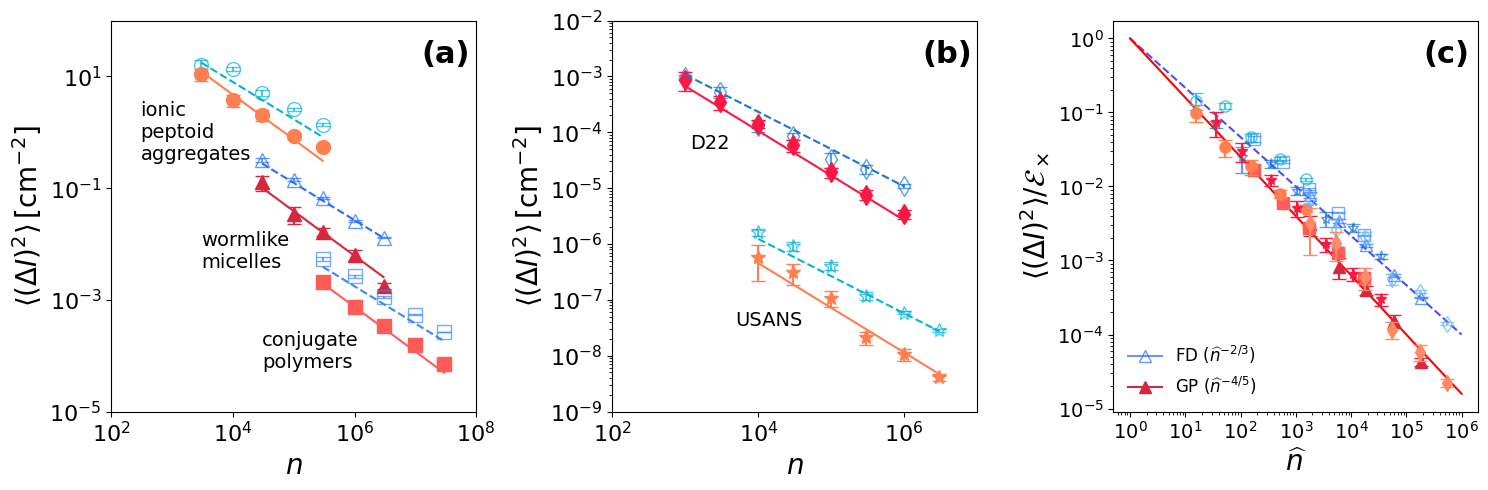

In [25]:
# --- Load all EQSAMS data ---
with open("plot_EQSANS.json", "r") as f:
    plot_EQSANS_loaded = json.load(f)
with open("plot_EQSANS_2.json", "r") as f:
    plot_EQSANS_2_loaded = json.load(f)
with open("plot_EQSANS_4.json", "r") as f:
    plot_EQSANS_4_loaded = json.load(f)
    
datasets = [
    ("wormlike\nmicelles", plot_EQSANS_loaded, [1e-3, 1e0], [1e4, 1e7], 'o'),
    ("conjugate\npolymers", plot_EQSANS_2_loaded, [1e-3, 1e0], [1e4, 1e7], 'o'),
    ("ionic\npeptoid\naggregates", plot_EQSANS_4_loaded, [1e-3, 1e0], [1e4, 1e7], 'o')
]   

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
# axes = [axes]

# Use more visually appealing red-ish and blue-ish color palettes
colors_red = ['#d7263d', '#ff5c57', '#ff7f50', '#ff1744', '#ff8a65']   # 5 red-ish colors
colors_blue = ['#256eff', '#3a86ff', '#00b4d8', '#1976d2', '#64b5f6']  # 5 blue-ish colors
symbols = ['^', 's', 'o']

seed = 114514
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for idx, (name, plot_loaded, ylim, xlim, marker) in enumerate(datasets):
    plot_fd_actual = plot_loaded[0]
    plot_gp_actual = plot_loaded[1]
    plot_parameters = plot_loaded[2]
    L, A0, beta, gamma = plot_parameters
    ax = axes[0]
    np.random.seed(seed+idx)

    # Plot FD actual points
    marker = symbols[idx % len(symbols)]
    # marker = 'o'
    color_b = colors_blue[idx % len(colors_blue)]
    # color_b = 'b'
    for total_counts, fd_actual, fd_actual_std in plot_fd_actual:
        fd_actual_p = (fd_actual + np.random.normal(0, fd_actual_std))*(2.0 ** (1.0 / 3.0) + (2.0 ** (-2.0 / 3.0))) / (2.0 ** (1.0 / 3.0)) # add latter term because a previous error in C_FD calculation
        ax.loglog(total_counts, fd_actual_p, marker=marker, color=color_b, markersize=10, fillstyle='none', alpha=0.7)
        ax.errorbar(total_counts, fd_actual_p, yerr=fd_actual_std, fmt='none', ecolor=color_b, elinewidth=1.5, capsize=5, alpha=0.7)

    # Plot GPR actual points
    color_r = colors_red[idx % len(colors_red)]
    # color_r = 'r'
    for i_c, (total_counts, gpr_actual, gpr_actual_std) in enumerate(plot_gp_actual):
        ax.loglog(total_counts, gpr_actual, marker=marker, color=color_r, markersize=10, fillstyle='full')
        ax.errorbar(total_counts, gpr_actual, yerr=gpr_actual_std, fmt='none', ecolor=color_r, elinewidth=1.5, capsize=5)
        
        if i_c == 0:
            ax.text(total_counts/10, gpr_actual/40, name, fontsize=14, color='k', verticalalignment='bottom', horizontalalignment='left')

    # Calculate theoretical curves
    total_counts_list = [pt[0] for pt in plot_fd_actual]
    fd_theoretical_mse_list = []
    gpr_theoretical_mse_list = []

    for total_counts in total_counts_list:
        alpha = A0 / total_counts
        chi = (alpha / beta) ** (2 / 3) * gamma / beta
        C_FD = (2.0 ** (1.0 / 3.0)) + (2.0 ** (-2.0 / 3.0))
        fd_theoretical_mse = (alpha ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
        C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
        gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
        fd_theoretical_mse_list.append(fd_theoretical_mse)
        gpr_theoretical_mse_list.append(gpr_theoretical_mse)

    ax.loglog(total_counts_list, fd_theoretical_mse_list, '--', color=color_b, label='FD Theory')
    ax.loglog(total_counts_list, gpr_theoretical_mse_list, '-', color=color_r, label='GPR Theory')

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\langle(\Delta I)^2\rangle\,[\mathrm{cm^{-2}}]$', fontsize=20)
# ax.grid(True, which='both', ls=':', alpha=0.7)
ax.tick_params(axis='both', labelsize=16)
ax.set_ylim([1e-5, 1e2])
ax.set_xlim([1e2, 1e8])

ax.text(0.85, 0.95, panel_labels[0], transform=ax.transAxes, fontsize=22, verticalalignment='top', fontweight='bold')

# --- Load other data ---
with open("plot_USANS.json", "r") as f:
    plot_USANS_loaded = json.load(f)
with open("plot_D22.json", "r") as f:
    plot_D22_loaded = json.load(f)

datasets_2 = [
    ("USANS", plot_USANS_loaded, [2e-9, 2e-6], [5e3, 5e6], '*'),
    ("D22", plot_D22_loaded, [1e-6, 2e-3], [5e2, 2e6], 'd')
]

ax = axes[1]
for idx, (name, plot_loaded, ylim, xlim, marker) in enumerate(datasets_2):
    plot_fd_actual = plot_loaded[0]
    plot_gp_actual = plot_loaded[1]
    plot_parameters = plot_loaded[2]
    L, A0, beta, gamma = plot_parameters
    np.random.seed(seed+idx)

    # Plot FD actual points
    color_b = colors_blue[idx % len(colors_blue)+2]
    # color_b = 'b'
    for total_counts, fd_actual, fd_actual_std in plot_fd_actual:
        fd_actual_p = (fd_actual + np.random.normal(0, fd_actual_std))*(2.0 ** (1.0 / 3.0) + (2.0 ** (-2.0 / 3.0))) / (2.0 ** (1.0 / 3.0)) # add latter term because a previous error in C_FD calculation
        ax.loglog(total_counts, fd_actual_p, marker=marker, color=color_b, markersize=10, fillstyle='none', alpha=0.7)
        ax.errorbar(total_counts, fd_actual_p, yerr=fd_actual_std, fmt='none', ecolor=color_b, elinewidth=1.5, capsize=5, alpha=0.7)

    # Plot GPR actual points
    color_r = colors_red[idx % len(colors_red)+2]
    # color_r = 'r'
    for i_c, (total_counts, gpr_actual, gpr_actual_std) in enumerate(plot_gp_actual):
        ax.loglog(total_counts, gpr_actual, marker=marker, color=color_r, markersize=10, fillstyle='full')
        ax.errorbar(total_counts, gpr_actual, yerr=gpr_actual_std, fmt='none', ecolor=color_r, elinewidth=1.5, capsize=5)
        
        if i_c == 0:
            ax.text(total_counts*4, gpr_actual/20, name, fontsize=14, color='k', verticalalignment='bottom', horizontalalignment='right')

    # Calculate theoretical curves
    total_counts_list = [pt[0] for pt in plot_fd_actual]
    fd_theoretical_mse_list = []
    gpr_theoretical_mse_list = []

    for total_counts in total_counts_list:
        alpha = A0 / total_counts
        chi = (alpha / beta) ** (2 / 3) * gamma / beta
        C_FD = (2.0 ** (1.0 / 3.0)) + (2.0 ** (-2.0 / 3.0))
        fd_theoretical_mse = (alpha ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
        C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
        gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
        fd_theoretical_mse_list.append(fd_theoretical_mse)
        gpr_theoretical_mse_list.append(gpr_theoretical_mse)

    ax.loglog(total_counts_list, fd_theoretical_mse_list, '--', color=color_b, label='FD Theory')
    ax.loglog(total_counts_list, gpr_theoretical_mse_list, '-', color=color_r, label='GPR Theory')

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\langle(\Delta I)^2\rangle\,[\mathrm{cm^{-2}}]$', fontsize=20)
# ax.grid(True, which='both', ls=':', alpha=0.7)
ax.tick_params(axis='both', labelsize=16)
ax.set_ylim([1e-9, 1e-2])
ax.set_xlim([1e2, 1e7])

ax.text(0.85, 0.95, panel_labels[1], transform=ax.transAxes, fontsize=22, verticalalignment='top', fontweight='bold')

# --- Load all data ---
# --- Load all EQSAMS data ---
with open("plot_EQSANS_2.json", "r") as f:
    plot_EQSANS_2_loaded = json.load(f)
with open("plot_EQSANS_4.json", "r") as f:
    plot_EQSANS_4_loaded = json.load(f)
with open("plot_USANS.json", "r") as f:
    plot_USANS_loaded = json.load(f)
with open("plot_EQSANS.json", "r") as f:
    plot_EQSANS_loaded = json.load(f)
with open("plot_D22.json", "r") as f:
    plot_D22_loaded = json.load(f)

datasets = [
    ("EQSANS", plot_EQSANS_loaded, [1e-3, 1e0], [1e4, 1e7], '^'),
    ("EQSANS_2", plot_EQSANS_2_loaded, [1e-3, 1e0], [1e4, 1e7], 's'),
    ("EQSANS_4", plot_EQSANS_4_loaded, [1e-3, 1e0], [1e4, 1e7], 'o'),
    ("D22", plot_D22_loaded, [1e-6, 2e-3], [5e2, 2e6], '*'),
    ("USANS", plot_USANS_loaded, [2e-9, 2e-6], [5e3, 5e6], 'd'),
]

ax4 = axes[2]

# Plot the universal theoretical curves just once
n_hat_theory = np.logspace(0, 6, 200)
ax4.loglog(n_hat_theory, n_hat_theory ** (-2/3), '--', color='b', alpha=0.7)
ax4.loglog(n_hat_theory, n_hat_theory ** (-4/5), '-', color='red')

# Flags to add data labels to the legend only once
fd_data_labeled, gp_data_labeled = False, False

# markers = ['o', 's', '^']

total_counts_theory = np.logspace(0, 7, 2)
# Iterate over datasets to plot the SCALED experimental data
for idx, (name, plot_loaded, ylim, xlim, marker) in enumerate(datasets):
    np.random.seed(seed + idx)
    
    plot_fd_actual = plot_loaded[0]
    plot_gp_actual = plot_loaded[1]
    plot_parameters = plot_loaded[2]
    L, A0, beta, gamma = plot_parameters

    # Calculate system-specific scaling constants
    C1 = (5/4) * (2 * math.pi)**(-2/5)
    C2 = 2**(1/3) + 2**(-2/3)
    n_cross = (C1 / C2)**(15/2) * (gamma**(3/2) * A0) / (beta**(5/2))
    E_cross = (C2)**6 * C1**(-5) * (beta**2) / gamma

    # Use consistent color palettes
    color_b = colors_blue[idx % len(colors_blue)]
    color_r = colors_red[idx % len(colors_red)]

    # Plot scaled FD actual points
    for total_counts, fd_actual, fd_actual_std in plot_fd_actual:
        fd_actual_p = (fd_actual + np.random.normal(0, fd_actual_std)) * C2 / (2.0 ** (1.0 / 3.0))
        n_hat_val = total_counts / n_cross
        E_hat_val = fd_actual_p / E_cross
        E_hat_std = fd_actual_std / E_cross

        label = r'FD ($\widehat{n}^{-2/3}$)' if not fd_data_labeled else None
        ax4.loglog(n_hat_val, E_hat_val, color=color_b, markersize=8, fillstyle='none', label=label, marker=marker, alpha=0.7)
        ax4.errorbar(n_hat_val, E_hat_val, yerr=E_hat_std, fmt='none', ecolor=color_b, elinewidth=1.5, capsize=5, alpha=0.7)
        if label: fd_data_labeled = True

    # Plot scaled GPR actual points
    for total_counts, gpr_actual, gpr_actual_std in plot_gp_actual:
        n_hat_val = total_counts / n_cross
        E_hat_val = gpr_actual / E_cross
        E_hat_std = gpr_actual_std / E_cross

        label = r'GP ($\widehat{n}^{-4/5}$)' if not gp_data_labeled else None
        ax4.loglog(n_hat_val, E_hat_val, color=color_r, markersize=8, fillstyle='full', label=label, marker=marker)
        ax4.errorbar(n_hat_val, E_hat_val, yerr=E_hat_std, fmt='none', ecolor=color_r, elinewidth=1.5, capsize=5)
        if label: gp_data_labeled = True
# Add legend to ax4, showing only one entry per label
handles, labels = ax4.get_legend_handles_labels()
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique and l is not None:
        unique[l] = h
ax4.legend(unique.values(), unique.keys(), fontsize=12, frameon=False, loc='lower left')
ax4.text(0.85, 0.95, panel_labels[2], transform=ax4.transAxes, fontsize=22, verticalalignment='top', fontweight='bold')

ax4.set_xlabel(r'$\widehat{n}$', fontsize=20)
ax4.set_ylabel(r'$\langle(\Delta I)^2\rangle/\mathcal{E}_\times$', fontsize=20)
ax4.tick_params(axis='both', labelsize=14)
ax4.set_xscale('log')
ax4.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax4.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
# ax4.grid(True, which='both', ls=':', alpha=0.7)
fig.tight_layout()
